In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [59]:
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets


import torch.optim as op
from torch.utils.tensorboard import SummaryWriter

In [3]:
import numpy as np
import scipy
import cv2
import random

In [4]:
import numpy.linalg as linalg
import matplotlib.pyplot as plt

In [18]:
#io
import glob
from PIL import Image
import os
import collections
import re
import sys
import datetime

In [6]:
# # Add module path to sys
# module_path = os.path.abspath(os.path.join('..'))
# print("System path: "+module_path)
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
# import micro_dl.utils.meta_utils as meta_utils

### Define Unet Architecture

In [6]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

In [7]:
# convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, dropout=False, norm='batch', residual=True, activation='relu',
                 transpose=False, num_layers = 3, filter_steps = 'first'):

        #----#
        # Convolutional block for lateral layers in Unet
        #     in_filters -> int: number of images in in stack
        #     out_filters -> int: number of images in out stack
        #     dropout -> float: dropout probability (False = 0)
        #     norm -> token{'batch', 'instance', 'mixed'}: normalization type
        #     residual -> boolean: as name
        #     activation -> token{'relu', 'leakyrelu', 'elu', 'selu'}: activation function
        #     final_activation -> token{'linear', 'nonlinear'}: final layer activation, 'linear' for regression tasks
        #     transpose -> boolean: as name
        #     num_layers -> int: as name
        #     filter_steps -> token{'linear','first','last'}: determines where in the block the filters inflate
        #                                                     channels (learn abstraction info)
        #----#
        # Format for layer initialization is as follows:
        #     if layer type specified 
        #     => for number of layers 
        #     => add layer to list of that layer type
        # This is done to allow for dynamic layer number specification in the conv blocks, which
        # allows us to change the parameter numbers of the network.
        #----#

        super(ConvBlock, self).__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.dropout = dropout
        self.norm = norm
        self.residual = residual
        self.activation = activation
        self.transpose = transpose
        self.num_layers = num_layers
        self.filter_steps = filter_steps
        
        #----- Init Dropout -----#
        if self.dropout:
            self.drop_list = []
            for i in range(self.num_layers):
                self.drop_list.append(nn.Dropout2d(int(self.dropout)))
        
        
        #----- Init Normalization Layers -----#
        #      => note: prefer batch normalization, but normalization can be mixed
        #
        self.norm_list = [None for i in range(num_layers)]
        if norm == 'batch':
            for i in range(self.num_layers):
                self.norm_list[i] = nn.BatchNorm2d(out_filters)
        elif norm == 'instance':
            for i in range(self.num_layers):
                self.norm_list[i] = nn.InstanceNorm2d(out_filters, affine=True)
        elif norm == 'mixed':
            for i in range(self.num_layers):
                if i < self.num_layers//2:
                    self.norm_list[i] = nn.BatchNorm2d(out_filters)
                else:
                    self.norm_list[i] = nn.InstanceNorm2d(out_filters, affine=True)
        
        #----- Init Conv Layers -----#
        #
        # init conv layers and determine transposition during convolution
        # The parameters governing the initiation logic flow are:
        #                 self.transpose
        #                 self.num_layers
        #                 self.filter steps
        # See above for definitions.
        #-------#
        
        self.conv_list = []
        steps = np.linspace(in_filters, out_filters, num_layers).astype(int)
        if self.filter_steps == 'linear':
            if self.transpose:
                for i in range(self.num_layers):
                    depth_pair = (steps[i], steps[i+1]) if i+1 < num_layers else (steps[i],steps[i])
                    self.conv_list.append(nn.ConvTranspose2d(depth_pair[0], depth_pair[1], kernel_size=3, padding=1))
            else:
                for i in range(self.num_layers):
                    depth_pair = (steps[i], steps[i+1]) if i+1 < num_layers else (steps[i],steps[i])
                    self.conv_list.append(nn.Conv2d(depth_pair[0], depth_pair[1], kernel_size=3, padding=1))
                    
        elif self.filter_steps == 'first':
            if self.transpose:
                for i in range(self.num_layers):
                    if i == 0:
                        self.conv_list.append(nn.ConvTranspose2d(in_filters, out_filters, kernel_size=3, padding=1))
                    else:
                        self.conv_list.append(nn.ConvTranspose2d(out_filters, out_filters, kernel_size=3, padding=1))
            else:
                for i in range(self.num_layers):
                    if i == 0:
                        self.conv_list.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1))
                    else:
                        self.conv_list.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1))
                        
        elif self.filter_steps == 'last':
            if self.transpose:
                for i in range(self.num_layers):
                    if i == self.num_layers-1:
                        self.conv_list.append(nn.ConvTranspose2d(in_filters, out_filters, kernel_size=3, padding=1))
                    else:
                        self.conv_list.append(nn.ConvTranspose2d(out_filters, out_filters, kernel_size=3, padding=1))
            else:
                for i in range(self.num_layers):
                    if i == self.num_layers-1:
                        self.conv_list.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1))
                    else:
                        self.conv_list.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1))
        
        #----- Init Activation Layers -----#
        self.act_list = []
        if self.activation == 'relu':
            for i in range(self.num_layers):
                self.act_list.append(nn.ReLU())
        elif self.activation == 'leakyrelu':
            for i in range(self.num_layers):
                self.act_list.append(nn.LeakyReLU())
        elif self.activation == 'elu':
            for i in range(self.num_layers):
                self.act_list.append(nn.ELU())
        elif self.activation == 'selu':
            for i in range(self.num_layers):
                self.act_list.append(nn.SELU())
        
    
    def forward(self, x):
        # Forward call of the conv block. 
        #    x -> image stack tensor: input to model
        #
        # Note: call order is convolution -> batch norm -> activation
        
        x_0 = x
        for i in range(self.num_layers):
            x = self.conv_list[i](x)
            if self.dropout:
                x = self.drop_list(x)
            if self.norm[i]:
                x = self.norm_list[i](x)
            if i < self.num_layers - 1:
                x = self.act_list[i](x)
        
        #residual summation comes before final activation layer
        if self.residual:
            if self.out_filters == 1: #preserve information for 5 -> 1 conv blocks
                x += torch.unsqueeze(torch.mean(x_0, axis = 1), 1)
            else:
                x[:, 0:min(x_0.shape[1], x.shape[1]), :, :] += x_0[:, 0:min(x_0.shape[1], x.shape[1]), :, :]
            
        #last activation could be linear in prediction block
        if self.activation != 'linear':
            x = self.act_list[-1](x)
        
        return x
    
    def model(self):
        # convolution -> normalization -> activation
        # We can make a list of layer modules and unpack them into nn.Sequential.
        #     Note: this is distinct from the forward call because we want to use the forward call with addition, since this
        #           is a residual block. The forward call performs the resid calculation, and all the parameters can be seen
        #           by the optimizer when given this model.
        layers = []
        
        for i in range(self.num_layers):
            layers.append(self.conv_list[i])
            if self.dropout:
                layers.append(self.drop_list[i])
            if self.norm[i]:
                layers.append(self.norm_list[i])
            if i < len(self.act_list):
                layers.append(self.act_list[i])
        
        return nn.Sequential(*layers)
            

In [8]:
class Unet2d(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1, out_xy = (256,256), residual = False, down = 'avgpool', up = 'bilinear',
                 activation = 'relu', num_blocks = 4, task = 'seg', num_filters = []):
        
        super(Unet2d, self).__init__()
        self.num_blocks = num_blocks
        self.residual = residual
        self.task = task
        self.out_xy = out_xy
        
        #----- Standardize Filter Sequence -----#
        if len(num_filters) != 0:
            assert len(num_filters) == num_blocks, 'Length of num_filters must be equal to num_blocks + 1 (number of convolutional blocks per path).'
            self.num_filters = num_filters
        else:
            self.num_filters = [pow(2,i)*16 for i in range(num_blocks + 1)]

            
        #----- Downsampling steps -----#
        self.down_list = []
        if down == 'maxpool':
            for i in range(num_blocks):
                self.down_list.append(nn.MaxPool2d(kernel_size=2))
        elif down == 'avgpool':
            for i in range(num_blocks):
                self.down_list.append(nn.AvgPool2d(kernel_size=2))
        elif down == 'conv':
            raise NotImplementedError('Not yet implemented!')
            #TODO: implement.
        
        #----- Upsampling steps -----#
        self.up_list = []
        if up == 'bilinear':
            for i in range(num_blocks):
                self.up_list.append(lambda x: nn.functional.interpolate(x, mode=up, scale_factor=2))
        elif up == 'conv':
            raise NotImplementedError('Not yet implemented!')
            #TODO: implement
        elif up == 'tconv':
            raise NotImplementedError('Not yet implemented!')
            #TODO: implement
        
        #----- Convolutional blocks -----# Forward Filters [16, 32, 64, 128, 256] -> Backward Filters [128+256, 64+128, 32+64, 16+32, 1]
        self.down_conv_blocks = []
        forward_filters = [in_channels] + self.num_filters
        for i in range(num_blocks):
            self.down_conv_blocks.append(ConvBlock(forward_filters[i], forward_filters[i+1], residual = self.residual, activation = activation))
        
        self.bottom_transition_block = ConvBlock(self.num_filters[-2], self.num_filters[-1])

        self.up_conv_blocks = []
        backward_filters = [self.num_filters[-(i+1)] + self.num_filters[-(i+2)] for i in range(len(self.num_filters)) if i < len(self.num_filters) - 1] + [out_channels]
        for i in range(num_blocks):
            self.up_conv_blocks.append(ConvBlock(backward_filters[i], forward_filters[-(i+2)], residual = self.residual, activation = activation))
            
        #----- Network-level residual-----#
        if self.residual:
            self.conv_resid = ConvBlock(self.num_filters[0], out_channels, residual = self.residual, activation = activation, num_layers = 1)
        else:
            self.conv_resid = ConvBlock(self.num_filters[0], out_channels, residual = self.residual, activation = activation, num_layers = 1)
        
        #----- Terminal Block and Activation Layer -----#
        if self.task == 'reg':
            self.terminal_block = ConvBlock(forward_filters[1], out_channels, residual = self.residual, activation = 'linear', num_layers = 1)
            self.linear_activation = nn.Linear(*self.out_xy)
        else:
            self.terminal_block = ConvBlock(forward_filters[1], out_channels, residual = self.residual, activation = activation, num_layers = 1)
        
    def forward(self, x):
        #encoder
        skip_tensors = []
        for i in range(self.num_blocks):
            x = self.down_conv_blocks[i](x)
            skip_tensors.append(x)
            x = self.down_list[i](x)
        
        #transition block
        x = self.bottom_transition_block(x)
        
        #decoder
        for i in range(self.num_blocks):
            x = self.up_list[i](x)
            x = torch.cat([x, skip_tensors[-1*(i+1)]], 1)
            x = self.up_conv_blocks[i](x)
        
        # output channel collapsing layer
        x = self.terminal_block(x)
        if self.task == 'reg':
            x = self.linear_activation(x)
        
        return x
    
    def model(self):
        # We can make a list of layer modules and unpack them into nn.Sequential.
        #     Note: this is distinct from the forward call because we want to use the forward call with addition, since this
        #           is a residual network. The forward call performs the resid calculation, and all the parameters can be seen
        #           by the optimizer when given this model.
        
        def get_block_layers(conv_block):
            block_layers = conv_block.model().children()
            return list(block_layers)
        
        layers = []

        #encoder blocks
        for i in range(self.num_blocks):
            layers.extend(get_block_layers(self.down_conv_blocks[i]))
            layers.append(self.down_list[i])
            
        #transition block
        layers.extend(get_block_layers(self.bottom_transition_block))
        
        #decoder blocks
        for i in range(self.num_blocks):
            #layers.append(self.up_list[i]) <-- We don't include the upsampling because it is a functional interpolation, not a module
            layers.extend(get_block_layers(self.up_conv_blocks[i]))
        
        #terminal block & activation
        layers.extend(get_block_layers(self.terminal_block))
        
        if self.task == 'reg':
            layers.append(self.linear_activation)
        
        
        return nn.Sequential(*layers)

In [9]:
class MyDataset(Dataset): 
    def __init__(self, img_dict, transform=None, target_transform=None):
        self.img_dict = img_dict
        self.keys = [key for key in img_dict]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_dict)

    def __getitem__(self, idx):
        key = self.keys[idx]
        phase = np.asarray(Image.open(self.img_dict[key][3]))
        #retardance = np.asarray(Image.open(self.img_dict[key][2]))
        #actin = np.asarray(Image.open(self.img_dict[key][1]))
        nuclei = np.asarray(Image.open(self.img_dict[key][0]))
        
        sample = {'image': phase, 'target': nuclei}
        if self.transform:
            sample = self.transform(sample)
        for key in sample:
            sample[key] = torch.unsqueeze(sample[key], 0)
        return sample
    
class Resize(object):
    def __init__(self, output_size = (256, 256)):
        self.output_size = output_size
    def __call__(self, sample):
        sample['image'] = cv2.resize(sample['image'], self.output_size)
        sample['target'] = cv2.resize(sample['target'], self.output_size)
        return sample

class RandTile(object):
    def __init__(self, tile_size = (256,256)):
        self.tile_size = tile_size
    def __call__(self,sample):
        assert self.tile_size[0] < sample['image'].shape[-1] and self.tile_size[1] < sample['image'].shape[-2], 'Sample size must be greater than tile size.'
               
        x, y = sample['image'].shape[-2], sample['image'].shape[-1]
        randx = np.random.randint(0, x - self.tile_size[1])
        randy = np.random.randint(0, y - self.tile_size[0])
        
        sample['image'] = sample['image'][randy:randy+self.tile_size[0], randx:randx+self.tile_size[1]]
        sample['target'] = sample['target'][randy:randy+self.tile_size[0], randx:randx+self.tile_size[1]]
        return sample
    
class Normalize(object):
    def __call__(self, sample):
        sample['image'] = sample['image']/np.max(sample['image'])
        sample['target'] = sample['target']/np.max(sample['target'])
        return sample
    
class RandFlip(object):
    def __call__(self, sample):
        rand = np.random.randint(0,2,2)
        image = sample['image'].copy()
        target = sample['target'].copy()
        if rand[0]==1:
            image = np.flipud(image)
            target = np.flipud(target)
        if rand[1]==1:
            image = np.fliplr(image)
            target = np.fliplr(target)
        sample['image'] = image
        sample['target'] = target
        return sample
    
class chooseBands(object):
    def __init__(self, bands = (0, 30)):
        self.bands = bands
    def __call__(self, sample):
        sample['image'] = sample['image'][...,self.bands[0]:self.bands[1]]
        return sample
    
class toTensor(object):
    def __call__(self, sample):
        sample['image'] = torch.tensor(sample['image'].copy(),dtype=torch.float32)
        sample['target'] = torch.tensor(sample['target'].copy(),dtype=torch.float32)
        return sample

### Data acquisition

In [10]:
data_directory = '../../../../../hpc/projects/compmicro/projects/virtualstaining/MBL_DL_image_translation/data/'
all_data = {}

In [11]:
def unique_tags(directory):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory,f))]
    
    tags = collections.defaultdict(lambda : 0)
    for f in files:
        f_name, f_type = f.split('.')[0], f.split('.')[1]
        if f_type == 'tif':
            suffixes = re.split('_', f_name)

            unique_tag = suffixes[2] + '_' + suffixes[3] + '_' + suffixes[4]
            tags[unique_tag + '.' + f_type] += 1
    return tags

In [12]:
train_samples = {}
test_samples = {}

for key in unique_tags(data_directory):
    measurements = glob.glob(data_directory + '*' + key)
    measurements.sort()
    num = random.uniform(0,1)
    if num < 0.9:
        train_samples[key] = measurements
    else:
        test_samples[key] = measurements

In [13]:
print(len(train_samples), len(test_samples))

158 22


Note the indices here are:<br>
    - 0: nuclei <br>
    - 1: actin<br>
    - 2: retardance<br>
    - 3: phase<br>

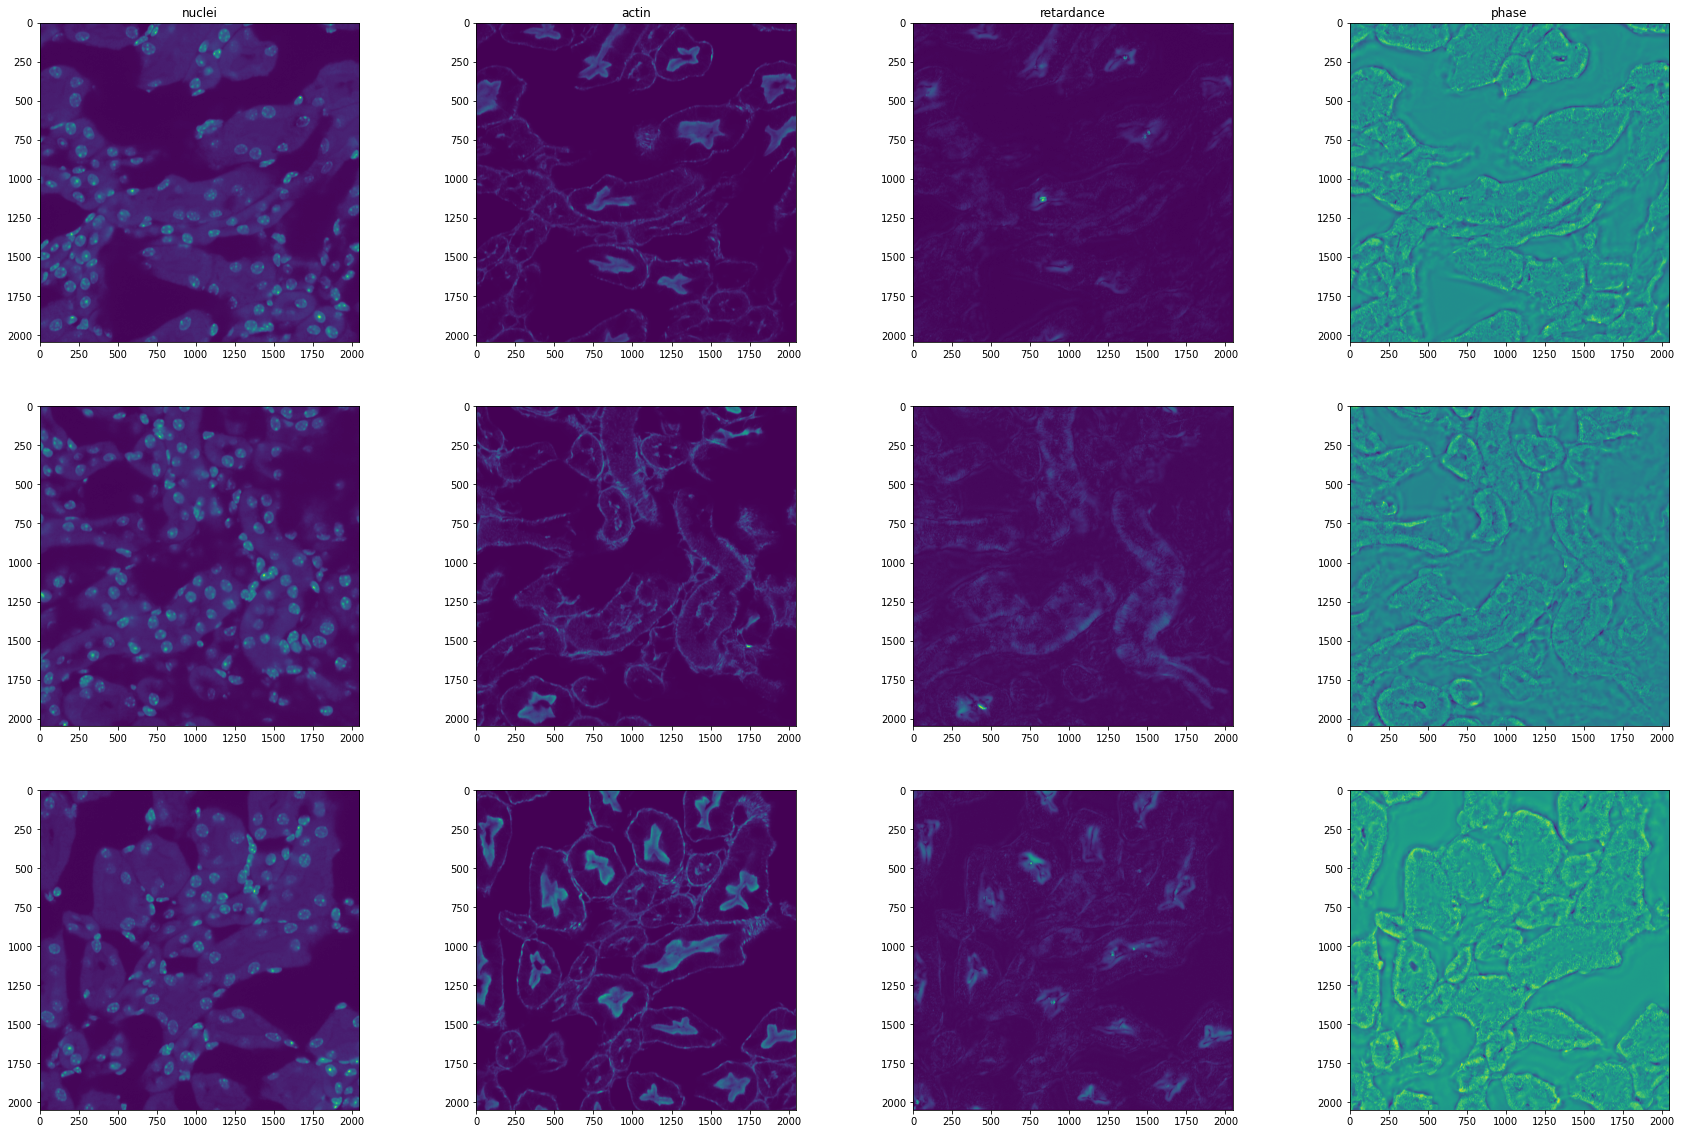

In [14]:
num = 3
keys = [key for key in train_samples]

fig, ax = plt.subplots(num, 4, figsize = (10*num, 20))
for i in range(num):
    if i == 0:
        ax[i][0].set_title('nuclei')
        ax[i][1].set_title('actin')
        ax[i][2].set_title('retardance')
        ax[i][3].set_title('phase')
    
    ax[i][0].imshow(Image.open(train_samples[keys[i]][0]))
    ax[i][1].imshow(Image.open(train_samples[keys[i]][1]))
    ax[i][2].imshow(Image.open(train_samples[keys[i]][2]))
    ax[i][3].imshow(Image.open(train_samples[keys[i]][3]))
plt.show()

### Train

In [16]:
device = torch.device('cuda')

In [26]:
learning_rate = 0.003
batch_size = 140
epochs = 1
in_channels = 1
out_channels = 1
residual = True
task = 'recon'

verbose = False

args_dict = { 'lr':learning_rate, 'bs':batch_size, 'in_channels':in_channels, 'out_channels':out_channels,
             'residual':residual, 'task':task, 'date':str(datetime.datetime.now())[:-7].replace(' ', '_')}
save_folder = os.path.join('../../../../../../hpc/projects/compmicro/projects', 
                      'virtualstaining/torch_microDL_models/Unet2d/checkpoint_' + "_".join(map(str, list(args_dict.values()))) + '/')

In [27]:
train_dataset = MyDataset(train_samples, transform = transforms.Compose([Resize(), Normalize(), RandFlip(), toTensor()]))
train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=False)

test_dataset = MyDataset(test_samples, transform = transforms.Compose([Resize(), Normalize(), RandFlip(), toTensor()]))
test_dataloader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

In [28]:
model = Unet2d(in_channels = in_channels, out_channels = out_channels, residual = residual, task = task)
model.model().cuda()

model.model() if verbose else None

In [29]:
criterion = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model().parameters(), lr = learning_rate)

In [30]:
def save_model(model, epoch, save_folder, test_loss):
    torch.save(model.state_dict(), save_folder + 'saved_model_ep' + str(epoch) + '_testloss'+str(test_loss) + '.pt')

In [31]:
def run_test(plot = True, epoch = 0, model = model, test_dataloader = test_dataloader,
            save_folder = save_folder):
    # Calculate the loss on the images in the test set
    test_loss = 0
    for sample in test_dataloader:
        #generate noisy
        noisy = sample['image'] + (np.random.rand(*sample['image'].shape)*0.2)
        noisy = noisy/np.max(noisy.numpy())
        
        #input and target
        input_ = noisy.to(device).float()
        target = sample['image'].to(device).float()
        #target = sample['target'].to(device)

        output = model(input_)
        loss = criterion(output, target)
        test_loss += loss.item()
    test_loss = test_loss/test_dataloader.__len__()
    
    if plot:
        fig, ax = plt.subplots(1,3,figsize = (18,6))
        ax[0].imshow(input_.detach().cpu().numpy()[0,0])
        ax[0].set_title('input noisy image')
        ax[1].imshow(target.detach().cpu().numpy()[0,0])
        ax[1].set_title('target denoised image')
        ax[2].imshow(output.detach().cpu().numpy()[0,0])
        ax[2].set_title(f'output image. loss: {test_loss}')
        plt.suptitle(f'epoch: {epoch}')
        plt.show()
    save_model(model, epoch, save_folder, test_loss)
    return test_loss


In [58]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
writer = SummaryWriter(log_dir = save_folder)
    
train_loss_list = []
test_loss_list = []
for i in range(epochs):
    train_loss = 0
    for sample in train_dataloader:
        
        #generate noise
        noisy = sample['image'] + (np.random.rand(*sample['image'].shape)*0.2)
        noisy = noisy/np.max(noisy.numpy())
        input_ = noisy.to(device).float()
        
        target = sample['image'].to(device).float()
        #target = sample['target'].to(device)
        
        output = model(input_)
        loss = criterion(output, target)
        train_loss += loss.item()
        
        # tensorboard writer
#         writer.add_scalar("Loss/train", loss, i)
#         writer.add_graph(model.model(), input_)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss_list.append(train_loss/train_dataset.__len__())
    
    if i % 10 == 0:
        test_loss = run_test(epoch = i)
        test_loss_list.append(test_loss/test_dataset.__len__())

writer.close()

Given groups=1, weight of size [128, 384, 3, 3], expected input[140, 256, 16, 16] to have 384 channels, but got 256 channels instead
Error occurs, No graph saved


RuntimeError: Given groups=1, weight of size [128, 384, 3, 3], expected input[140, 256, 16, 16] to have 384 channels, but got 256 channels instead

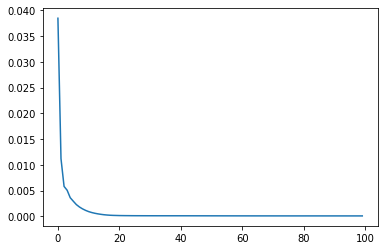

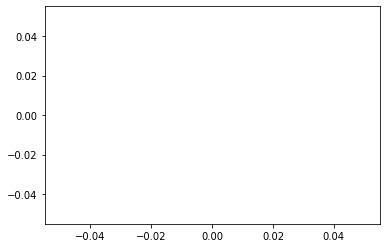

In [175]:
plt.plot(train_loss_list)
plt.show()
plt.plot(test_loss_list)
plt.show()

In [ ]:
for p in optimizer.param_groups:
    a = p['params'][0].data.detach().cpu().numpy()
    for i in range(a.shape[0]):
        plt.imshow(a[i,0])
        plt.show()

### Useful but unused code

In [ ]:
#randomnoise transformation
class RandomNoise(object):
    def __init__(self, noise_type):
        self.noise_type = noise_type
    def __call__(self, sample):
        if noise_typ == "gauss":
            row,col,ch= image.shape
            mean = 0
            var = 0.1
            sigma = var**0.5
            gauss = np.random.normal(mean,sigma,(row,col,ch))
            gauss = gauss.reshape(row,col,ch)
            noisy = image + gauss
            return noisy
        
        elif noise_typ == "s&p":
            row,col,ch = image.shape
            s_vs_p = 0.5
            amount = 0.004
            out = np.copy(image)
            # Salt mode
            num_salt = np.ceil(amount * image.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
            out[coords] = 1

            # Pepper mode
            num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
            out[coords] = 0
            return out
        
        elif noise_typ == "poisson":
            vals = len(np.unique(image))
            vals = 2 ** np.ceil(np.log2(vals))
            noisy = np.random.poisson(image * vals) / float(vals)
            return noisy
        
        elif noise_typ =="speckle":
            row,col,ch = image.shape
            gauss = np.random.randn(row,col,ch)
            gauss = gauss.reshape(row,col,ch)        
            noisy = image + image * gauss
            return noisy

In [29]:
train_dataset = datasets.MNIST(root = 'dataset/', train=True, transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = datasets.MNIST(root = 'dataset/', train=False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

1.6%

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

94.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

